In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB7
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
import time
from collections import Counter
import os
import tensorflow as tf

2024-07-27 14:20:13.842929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 14:20:13.843049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 14:20:13.967056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set up the mirrored strategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

In [3]:
# Paths to your data directories
train_data_dir = '/kaggle/input/fer24-ck-6000-600-600-noenhance-7emo/FER24_CK+_6000+_600_600_NoEnhance_7Emo/train'
validation_data_dir = '/kaggle/input/fer24-ck-6000-600-600-noenhance-7emo/FER24_CK+_6000+_600_600_NoEnhance_7Emo/valid'
test_data_dir = '/kaggle/input/fer24-ck-6000-600-600-noenhance-7emo/FER24_CK+_6000+_600_600_NoEnhance_7Emo/test'
image_size = (224, 224)
batch_size = 32
num_classes = 7

In [4]:
# ImageDataGenerator for training, validation, and test data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Define a function to get images and labels
def get_data_generator(directory, datagen, batch_size, image_size, color_mode, shuffle=True):
    return datagen.flow_from_directory(
        directory,
        target_size=image_size,
        batch_size=batch_size,
        color_mode=color_mode,
        class_mode='categorical',
        shuffle=shuffle
    )

train_generator = get_data_generator(train_data_dir, train_datagen, batch_size, image_size, 'grayscale')
validation_generator = get_data_generator(validation_data_dir, valid_test_datagen, batch_size, image_size, 'grayscale')
test_generator = get_data_generator(test_data_dir, valid_test_datagen, batch_size, image_size, 'grayscale', shuffle=False)

Found 48618 images belonging to 7 classes.
Found 4200 images belonging to 7 classes.
Found 4200 images belonging to 7 classes.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


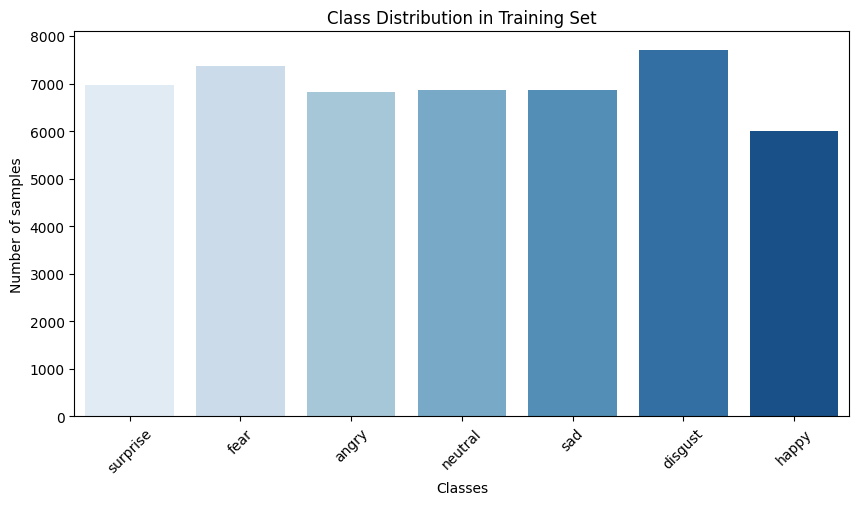

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


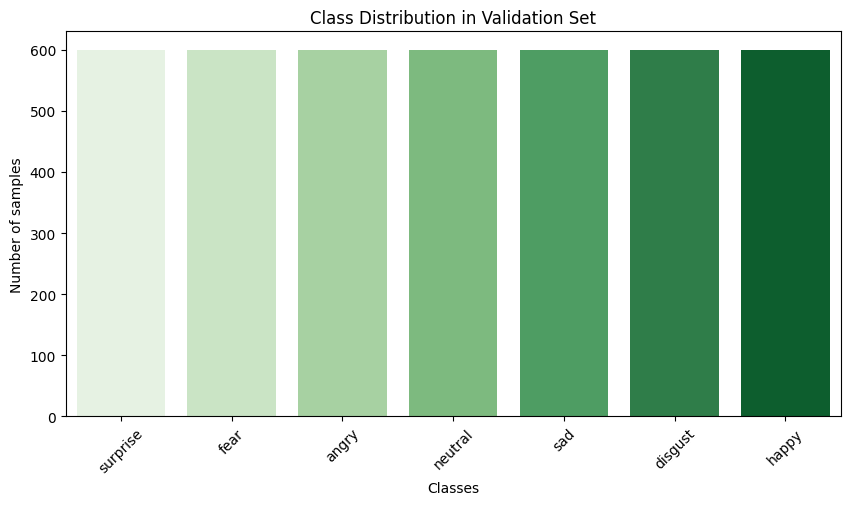

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


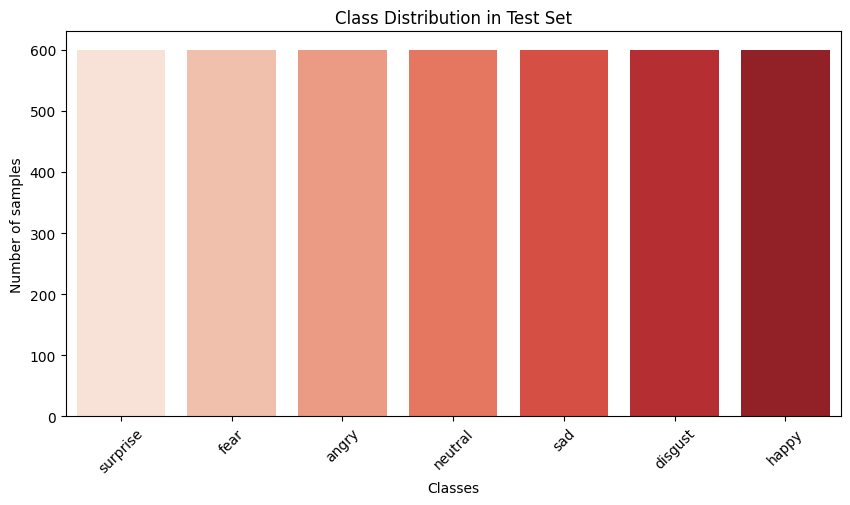

In [5]:
# Plot class distribution
def plot_class_distribution(directory, title, color):
    class_names = os.listdir(directory)
    class_counts = Counter()
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            num_images = len(os.listdir(class_dir))
            class_counts[class_name] = num_images
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette=color)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of samples')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_data_dir, 'Class Distribution in Training Set', 'Blues')
plot_class_distribution(validation_data_dir, 'Class Distribution in Validation Set', 'Greens')
plot_class_distribution(test_data_dir, 'Class Distribution in Test Set', 'Reds')

In [6]:
with strategy.scope():

    base_model = EfficientNetB7(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# Track training time
start_time = time.time()
with tf.device("/GPU:0"):
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size)
end_time = time.time()
training_time = end_time - start_time

Epoch 1/20


2024-07-27 14:26:42.747749: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_5084/cond/StatefulPartitionedCall/replica_1/sequential_1/efficientnetb7_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1519/1519 ━━━━━━━━━━━━━━━━━━━━ 2672s 1s/step - accuracy: 0.4827 - loss: 1.3456 - val_accuracy: 0.7204 - val_loss: 0.7407
Epoch 2/20
   1/1519 ━━━━━━━━━━━━━━━━━━━━ 32:27 1s/step - accuracy: 0.7500 - loss: 0.6747

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1519/1519 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7500 - loss: 0.6539 - val_accuracy: 1.0000 - val_loss: 0.1277
Epoch 3/20
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 2070s 1s/step - accuracy: 0.7171 - loss: 0.7717 - val_accuracy: 0.7643 - val_loss: 0.6529
Epoch 4/20
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 2s 131us/step - accuracy: 0.8125 - loss: 0.8472 - val_accuracy: 0.7500 - val_loss: 0.5620
Epoch 5/20
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 2078s 1s/step - accuracy: 0.7771 - loss: 0.6162 - val_accuracy: 0.7581 - val_loss: 0.6943
Epoch 6/20
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 1s 132us/step - accuracy: 0.9375 - loss: 0.4025 - val_accuracy: 0.5000 - val_loss: 1.8350
Epoch 7/20
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 2060s 1s/step - accuracy: 0.8126 - loss: 0.5227 - val_accuracy: 0.7719 - val_loss: 0.7095
Epoch 8/20
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 2s 121us/step - accuracy: 0.8125 - loss: 0.3938 - val_accuracy: 1.0000 - val_loss: 0.2536
Epoch 9/20
1519/1519 ━━━━━━━━━━━━━━━━━━━━ 2060s 1s/step - accuracy: 0.8368 - loss: 0.4537

In [8]:
# Print maximum accuracy
max_acc = max(history.history['val_accuracy'])
print("\n\nMaximum Accuracy Reached Is:", max_acc)



Maximum Accuracy Reached Is: 1.0


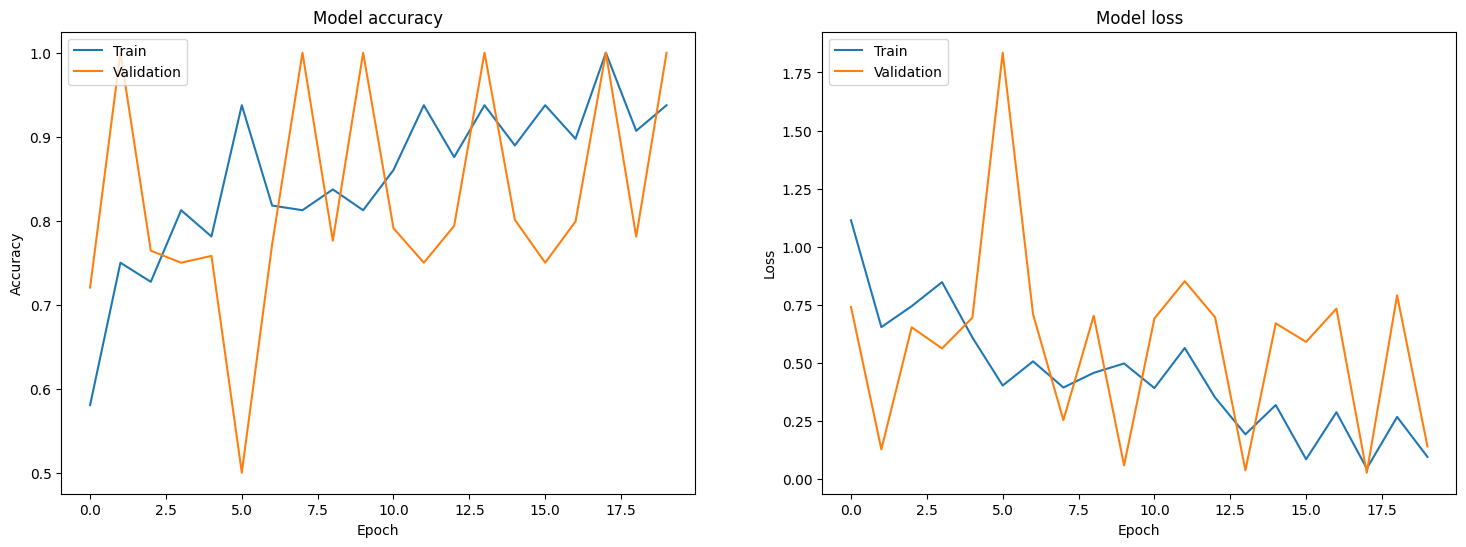

In [11]:
# Plot training & validation accuracy values
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Similarly, you can plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

132/132 ━━━━━━━━━━━━━━━━━━━━ 105s 623ms/step


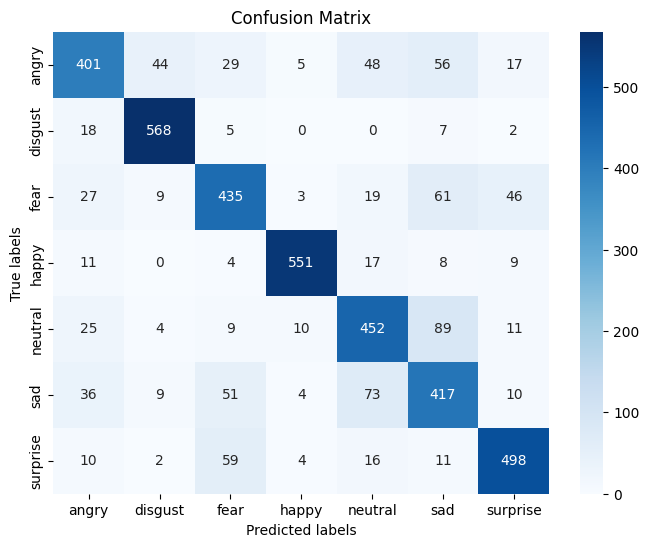

In [12]:
# Predict classes for test set
test_generator.reset()  # Reset the generator to avoid any state issues
Y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# Ensure the ground truth labels also cover all samples
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices, yticklabels=train_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Evaluate the model on the training data
results = model.evaluate(train_generator, steps=train_generator.samples // batch_size, verbose=2)
print('\nTraining results:', results)

# Unpack individual metrics
train_loss, train_acc = results
print('\nTraining accuracy:', train_acc)
#print('\nTraining precision:', train_precision)
#print('\nTraining recall:', train_recall)

# Evaluate the model on the test data
results = model.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=2)
print('\nTest results:', results)

# Unpack individual metrics
val_loss, val_acc = results
print('\nValidation accuracy:', val_acc)
#print('\nValidation precision:', val_precision)
#print('\nValidation recall:', val_recall)

1519/1519 - 398s - 262ms/step - accuracy: 0.9366 - loss: 0.1840

Training results: [0.18397338688373566, 0.9365947842597961]

Training accuracy: 0.9365947842597961
131/131 - 31s - 240ms/step - accuracy: 0.7872 - loss: 0.8070

Test results: [0.8070437908172607, 0.7872137427330017]

Validation accuracy: 0.7872137427330017


In [23]:
import pandas as pd
# Classification Report
print(classification_report(test_generator.classes, y_pred, target_names=train_generator.class_indices.keys()))

# Tabulate cost efficiency information including accuracy and validation accuracy for each epoch
epochs = len(history.history['accuracy'])
cost_efficiency_data = {
    "Epoch": list(range(1, epochs + 1)),
    "Training Accuracy": history.history['accuracy'],
    "Validation Accuracy": history.history['val_accuracy']
}

cost_efficiency_df = pd.DataFrame(cost_efficiency_data)
print(cost_efficiency_df)

# Summary of overall cost efficiency
summary_data = {
    "Metric": ["Training Time (seconds)", "Final Validation Accuracy", "Final Training Accuracy", "Training Accuracy", "Test Accuracy"],
    "Value": [training_time, history.history['val_accuracy'][-1], history.history['accuracy'][-1], train_acc, val_acc]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df)

              precision    recall  f1-score   support

       angry       0.76      0.67      0.71       600
     disgust       0.89      0.95      0.92       600
        fear       0.73      0.72      0.73       600
       happy       0.95      0.92      0.94       600
     neutral       0.72      0.75      0.74       600
         sad       0.64      0.69      0.67       600
    surprise       0.84      0.83      0.83       600

    accuracy                           0.79      4200
   macro avg       0.79      0.79      0.79      4200
weighted avg       0.79      0.79      0.79      4200

    Epoch  Training Accuracy  Validation Accuracy
0       1           0.580538             0.720420
1       2           0.750000             1.000000
2       3           0.727247             0.764313
3       4           0.812500             0.750000
4       5           0.781254             0.758111
5       6           0.937500             0.500000
6       7           0.818055             0.771947
7  